In [ ]:
import anndata as ad
import scvelo as scv
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import palantir
import numpy as np
from sklearn.metrics import pairwise_distances

# Load the velocyto loom file
ldata = sc.read("data/103.self_workflow/velocyto_combined.loom", cache=False)

# Set plotting settings
scv.settings.set_figure_params('scvelo', figsize=(10, 8))
adata = ad.read_h5ad('data/110.adipo/sc_adipo.h5ad')

In [2]:
# Make sure cell names match between anndata objects
ldata.obs.index = [x.split(':')[1] if ':' in x else x for x in ldata.obs.index]
ldata.obs.index = ldata.obs.index.str.replace('x', '')

# # Check for and handle duplicates in ldata index
# if ldata.obs.index.duplicated().any():
# 	print(f"Found {sum(ldata.obs.index.duplicated())} duplicated indices in ldata")
# 	# Make indices unique by adding a suffix to duplicates
# 	ldata.obs.index = ldata.obs.index.astype(str) + '_' + ldata.obs.groupby(level=0).cumcount().astype(str)
# 	# Remove the '_0' suffix from non-duplicated indices
# 	ldata.obs.index = [idx[:-2] if idx.endswith('_0') else idx for idx in ldata.obs.index]

# Print info about our datasets to verify
print(f"adata shape: {adata.shape}")
print(f"ldata shape: {ldata.shape}")
print(f"Common cells: {len(set(adata.obs.index) & set(ldata.obs.index))}")

# Add spliced/unspliced data to our original adata object
adata = scv.utils.merge(adata, ldata)

adata shape: (12516, 33177)
ldata shape: (80603, 33836)
Common cells: 10561


Normalized count data: spliced, unspliced.
Logarithmized X.
computing neighbors


/workspaces/AML/scveloenv/lib/python3.12/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_238779/827934473.py:3: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata)
/workspaces/AML/scveloenv/lib/python3.12/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:28) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/64 cores)
or disable the progress bar using `show_progress_bar=False`.


/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=238779) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/workspaces/AML/scveloenv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=238779) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


    finished (0:06:21) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:36) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 8/64 cores)


/opt/conda/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=238779) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


    finished (0:00:34) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'velocity_adipo_umap', embedded velocity vectors (adata.obsm)


/workspaces/AML/scveloenv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/workspaces/AML/scveloenv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/workspaces/AML/scveloenv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/workspaces/AML/scveloenv/lib/python3.12/site-packages/scvelo/plotting/utils.py:68: D

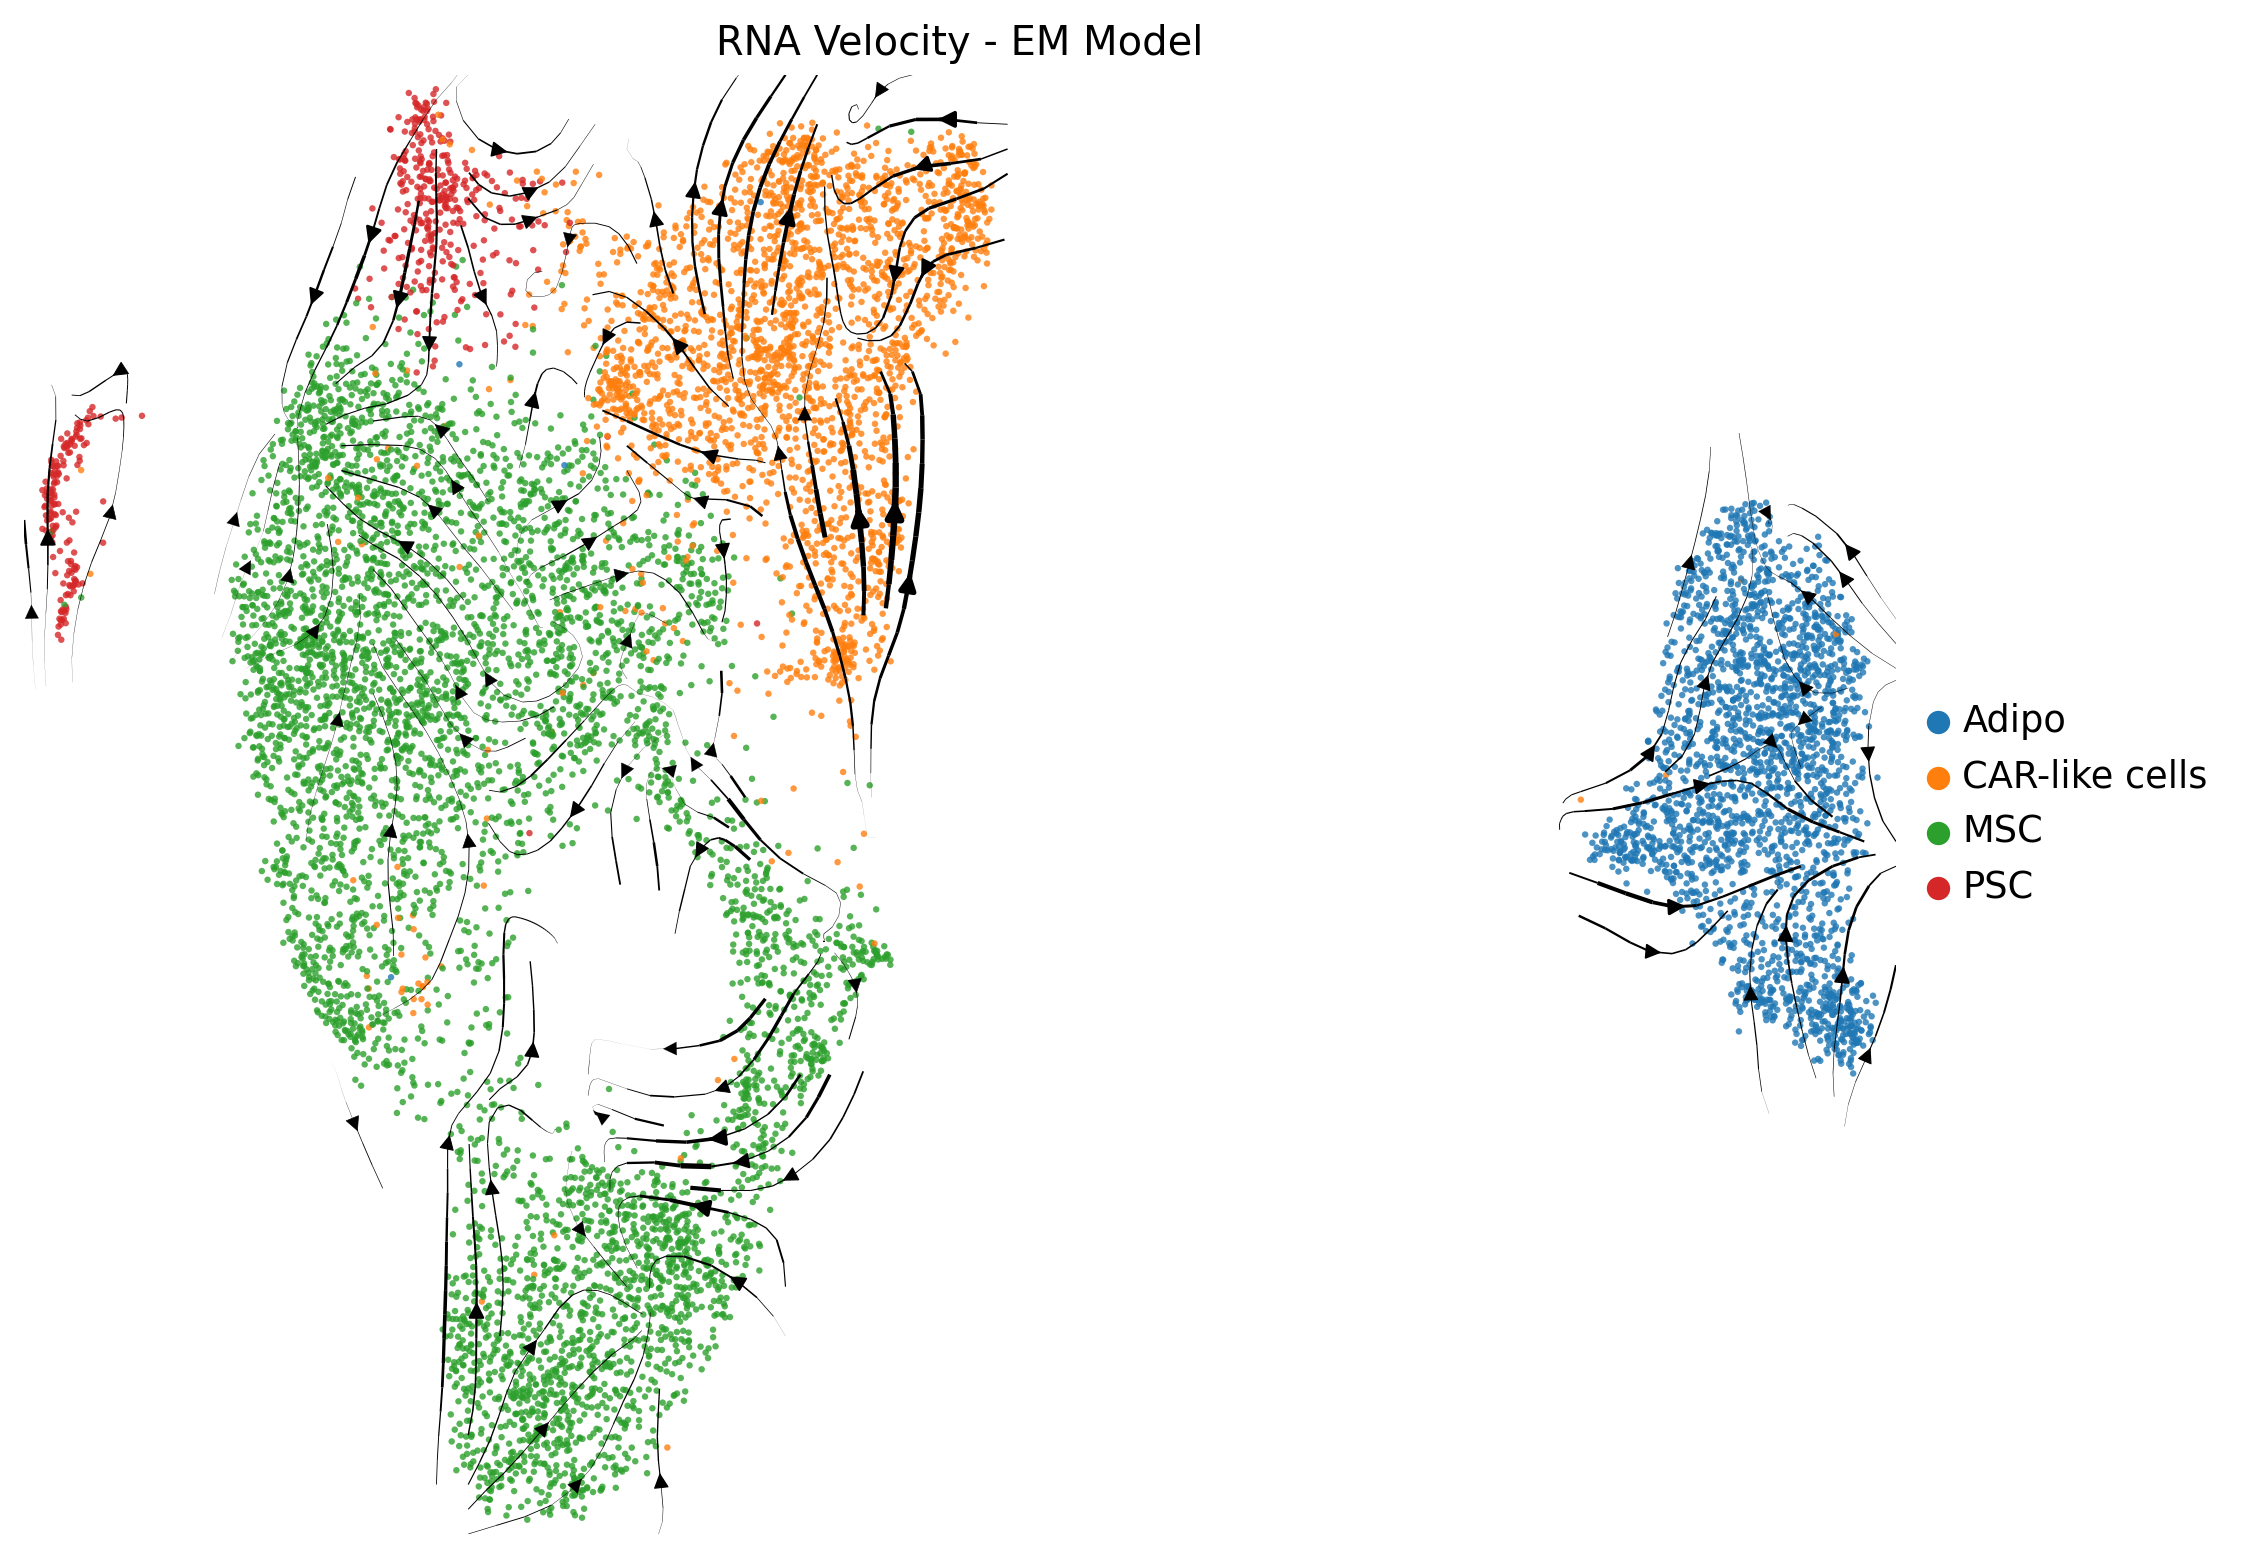

<Figure size 1000x800 with 0 Axes>

In [3]:

# Preprocessing and computing velocity
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata, n_jobs=8)

# Plot velocity stream with cells colored by cell_type_dtl
scv.pl.velocity_embedding_stream(adata, basis='X_adipo_umap', color='cell_type_dtl',
                                legend_loc='right', title='RNA Velocity - EM Model', 
                                size=15, alpha=0.8, dpi=120)

plt.tight_layout()

Creating diffusion map using Palantir...
Computing diffusion components...
Plotting diffusion map...


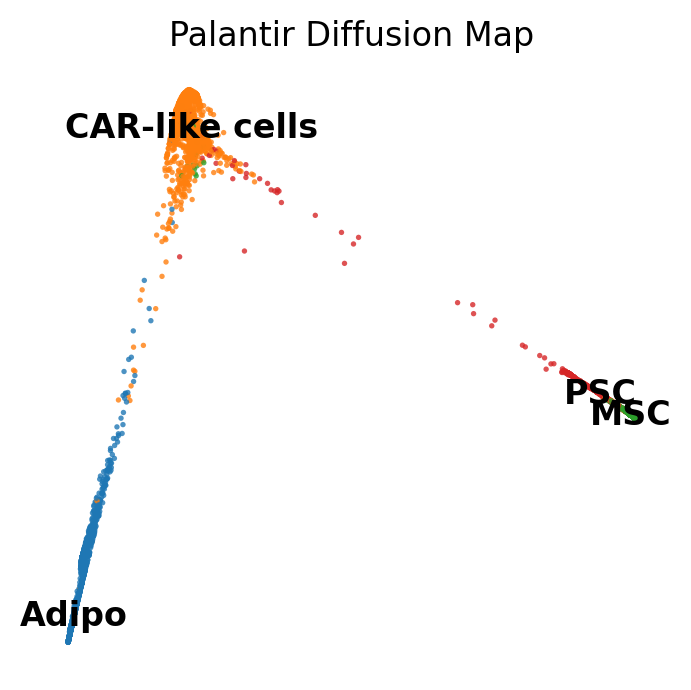

<Figure size 400x400 with 0 Axes>

Computing tSNE on diffusion components...
Plotting tSNE of diffusion map...


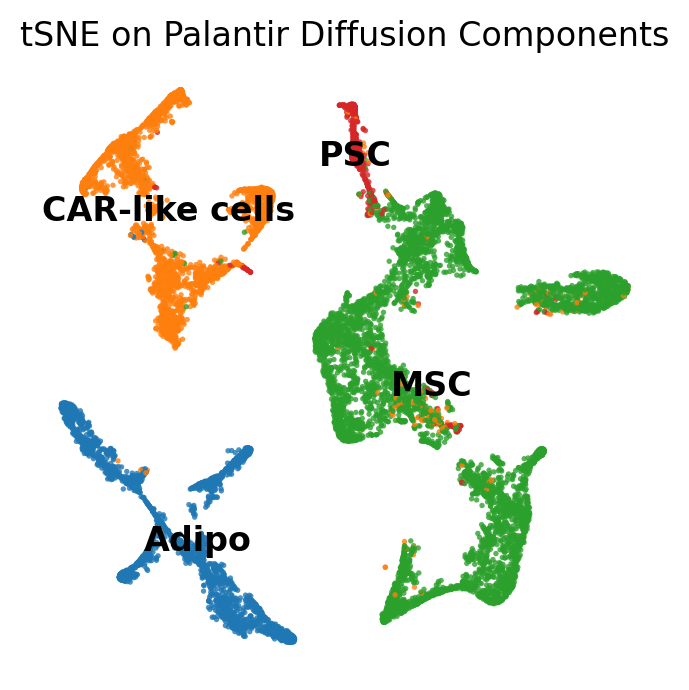

<Figure size 400x400 with 0 Axes>

In [23]:
# Create diffusion map using Palantir
print('Creating diffusion map using Palantir...')

import palantir
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
# First, we need to prepare data for Palantir
# 通常使用PCA结果作为Palantir输入
if 'X_pca' not in adata.obsm:
    print('Computing PCA first...')
    sc.pp.pca(adata)

# 创建Palantir所需的数据矩阵
pca_data = pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names)

# 计算扩散图
print('Computing diffusion components...')
dm_res = palantir.utils.run_diffusion_maps(pca_data, n_components=20)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
# Store the diffusion components in adata
adata.obsm['X_diffmap'] = ms_data.values[:, :2] # Using first 2 components for 2D visualization

# Plot the diffusion map
print('Plotting diffusion map...')
sc.pl.embedding(adata, basis='X_diffmap', color='cell_type_dtl', 
                title='Palantir Diffusion Map', legend_loc='on data',
                frameon=False, size=15, alpha=0.8)
plt.tight_layout()
plt.show()

# Optionally, if you want to visualize with tSNE on Palantir's diffusion components:
print('Computing tSNE on diffusion components...')
tsne = TSNE(n_components=2, random_state=42, perplexity=min(150, ms_data.shape[0]-1)) # Adjust perplexity if needed
tsne_components = tsne.fit_transform(ms_data)
adata.obsm['X_tsne_palantir'] = tsne_components

print('Plotting tSNE of diffusion map...')
sc.pl.embedding(adata, basis='X_tsne_palantir', color='cell_type_dtl',
                title='tSNE on Palantir Diffusion Components', legend_loc='on data',
                frameon=False, size=15, alpha=0.8)
plt.tight_layout()
plt.show()